🔹 Training KNN classifier...
Skipping data/train/person1/p1_5.jpg: found 3 faces.
Chose n_neighbors automatically: 3
Model trained and saved as trained_knn_model.clf
Training complete!

🔹 Predicting for test_person4.jpeg...
Found person1 at (45, 32, 107, 94)


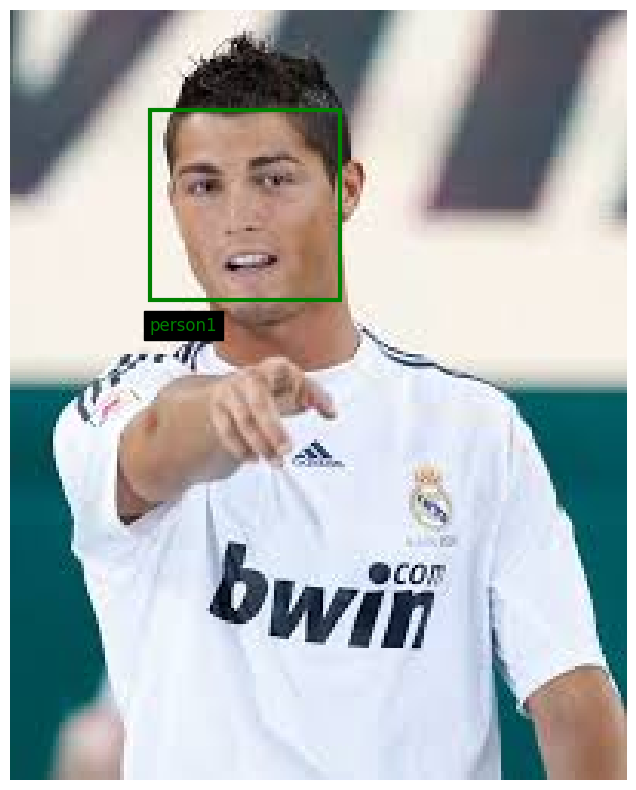

🔹 Predicting for p.jpg...
Found person2 at (373, 64, 528, 219)


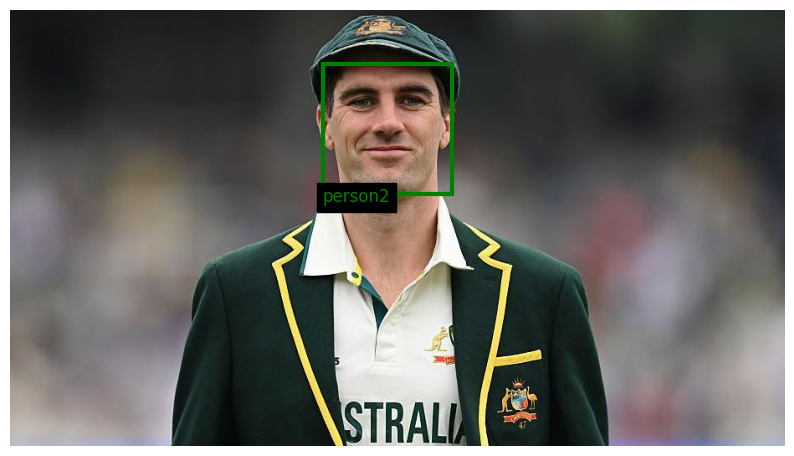

🔹 Predicting for test_person3.png...
Found unknown at (126, 66, 215, 156)


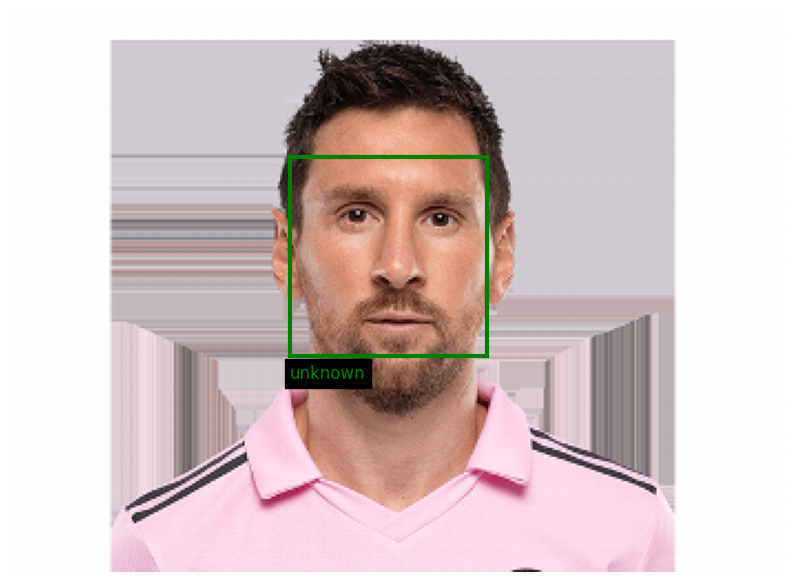

🔹 Predicting for test_person2.jpeg...
Found unknown at (66, 66, 155, 156)


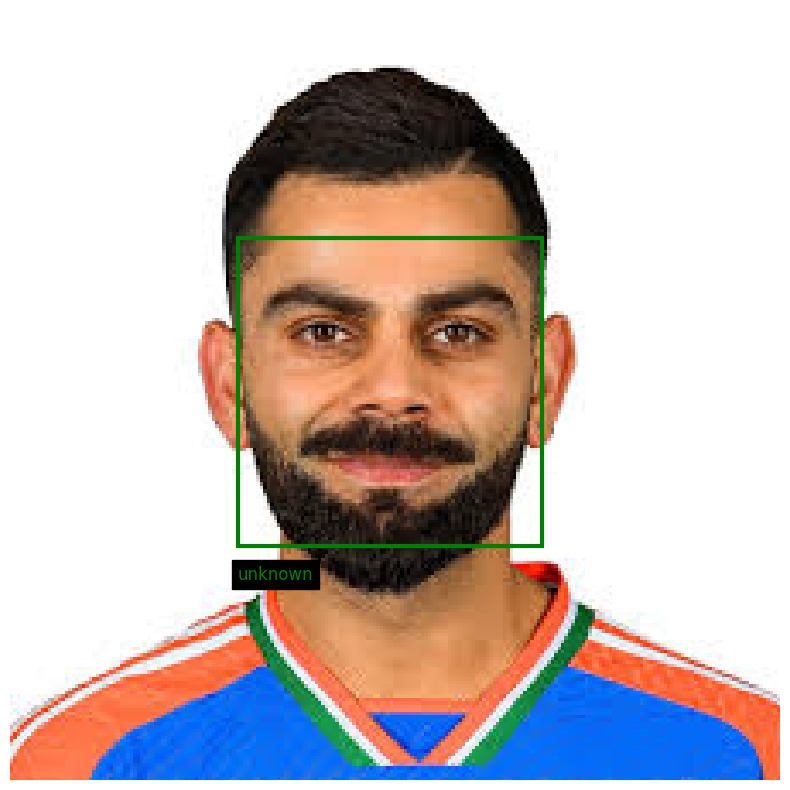

🔹 Predicting for test_person1.jpeg...
Found person1 at (36, 56, 126, 146)


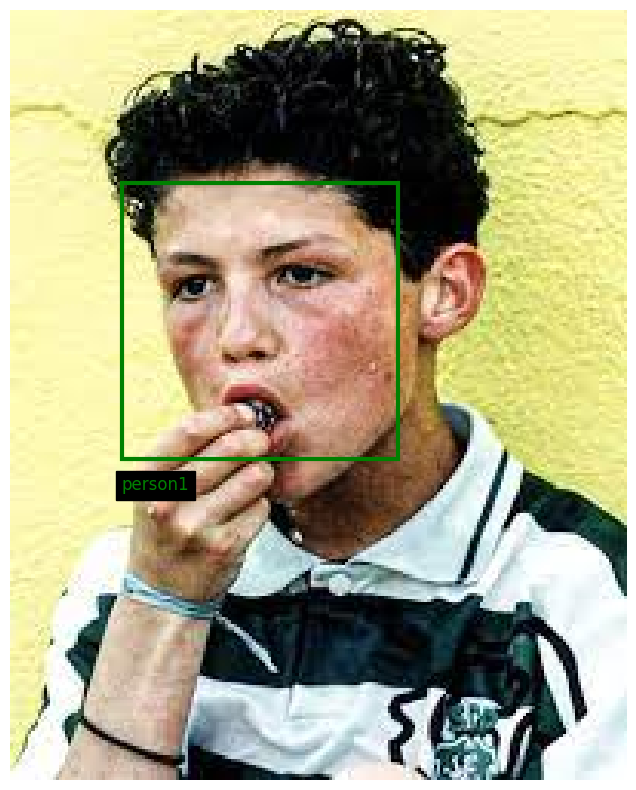

🔹 Predicting for m.webp...
Found person2 at (82, 171, 349, 439)


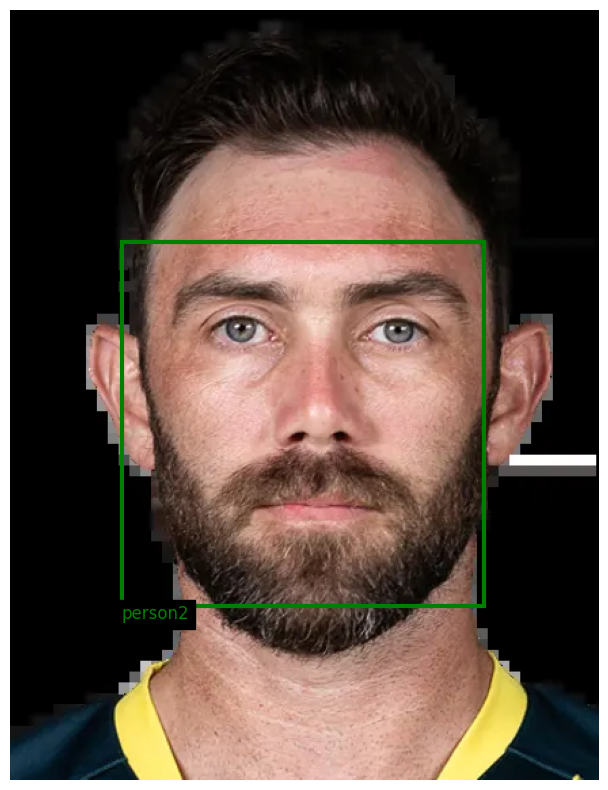

In [2]:
import os
import math
import pickle
from PIL import Image
import numpy as np
from sklearn import neighbors
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg', 'webp'}


# Training KNN Model
def train(train_dir, model_save_path="trained_knn_model.clf", n_neighbors=None, knn_algo='ball_tree'):
    X, y = [], []

    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        for img_path in image_files_in_folder(class_path):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                print(f"Skipping {img_path}: found {len(face_bounding_boxes)} faces.")
                continue

            X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
            y.append(class_dir)

    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        print(f"Chose n_neighbors automatically: {n_neighbors}")

    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    with open(model_save_path, 'wb') as f:
        pickle.dump(knn_clf, f)
    print(f"Model trained and saved as {model_save_path}")
    return knn_clf


# Prediction Function
def predict(image_path, model_path="trained_knn_model.clf", distance_threshold=0.6):
    if not os.path.isfile(image_path):
        raise Exception(f"Invalid image path: {image_path}")

    with open(model_path, 'rb') as f:
        knn_clf = pickle.load(f)

    X_img = face_recognition.load_image_file(image_path)
    X_face_locations = face_recognition.face_locations(X_img)

    if len(X_face_locations) == 0:
        return []

    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    return [
        (pred, loc) if rec else ("unknown", loc)
        for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)
    ]


# Display Predictions with matplotlib
def show_predictions(image_path, predictions):
    image = Image.open(image_path).convert("RGB")
    np_image = np.array(image)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(np_image)

    for name, (top, right, bottom, left) in predictions:
        rect = patches.Rectangle((left, top), right-left, bottom-top, linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(left, bottom+10, name, color='g', fontsize=12, backgroundcolor='black')

    plt.axis('off')
    plt.show()


# Main Execution
if __name__ == "__main__":
    TRAIN_DIR = "data/train"
    TEST_DIR = "data/test"
    MODEL_PATH = "trained_knn_model.clf"

    print("🔹 Training KNN classifier...")
    model = train(TRAIN_DIR, model_save_path=MODEL_PATH)
    print("Training complete!\n")

    for file in os.listdir(TEST_DIR):
        full_path = os.path.join(TEST_DIR, file)
        print(f"🔹 Predicting for {file}...")
        preds = predict(full_path, model_path=MODEL_PATH)
        for name, (top, right, bottom, left) in preds:
            print(f"Found {name} at ({left}, {top}, {right}, {bottom})")
        show_predictions(full_path, preds)


In [3]:
import cv2
import face_recognition
import pickle
from PIL import Image
import numpy as np
import math
from sklearn import neighbors


# Load Trained KNN Model
MODEL_PATH = "trained_knn_model.clf"
with open(MODEL_PATH, 'rb') as f:
    knn_clf = pickle.load(f)

# Distance threshold
DIST_THRESHOLD = 0.6


# Initialize Webcam
video_capture = cv2.VideoCapture(0)

print("🎥 Starting webcam. Press 'q' to quit.")

while True:
    ret, frame = video_capture.read()
    if not ret:
        break

    # Convert frame from BGR to RGB
    rgb_frame = frame[:, :, ::-1]

    # Find all faces in the frame
    face_locations = face_recognition.face_locations(rgb_frame)
    if face_locations:
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)

        predictions = []
        for encoding in face_encodings:
            closest_distances = knn_clf.kneighbors([encoding], n_neighbors=1)
            is_match = closest_distances[0][0][0] <= DIST_THRESHOLD
            name = knn_clf.predict([encoding])[0] if is_match else "unknown"
            predictions.append(name)

        # Draw bounding boxes and names
        for (top, right, bottom, left), name in zip(face_locations, predictions):
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(frame, name, (left, bottom + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow('KNN Face Recognition', frame)

    # Quit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()


🎥 Starting webcam. Press 'q' to quit.


TypeError: compute_face_descriptor(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),numpy.uint8], face: _dlib_pybind11.full_object_detection, num_jitters: int = 0, padding: float = 0.25) -> _dlib_pybind11.vector
    2. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),numpy.uint8], num_jitters: int = 0) -> _dlib_pybind11.vector
    3. (self: _dlib_pybind11.face_recognition_model_v1, img: numpy.ndarray[(rows,cols,3),numpy.uint8], faces: _dlib_pybind11.full_object_detections, num_jitters: int = 0, padding: float = 0.25) -> _dlib_pybind11.vectors
    4. (self: _dlib_pybind11.face_recognition_model_v1, batch_img: list[numpy.ndarray[(rows,cols,3),numpy.uint8]], batch_faces: list[_dlib_pybind11.full_object_detections], num_jitters: int = 0, padding: float = 0.25) -> _dlib_pybind11.vectorss
    5. (self: _dlib_pybind11.face_recognition_model_v1, batch_img: list[numpy.ndarray[(rows,cols,3),numpy.uint8]], num_jitters: int = 0) -> _dlib_pybind11.vectors

Invoked with: <_dlib_pybind11.face_recognition_model_v1 object at 0x74fabcd38df0>, array([[[175, 194, 185],
        [175, 194, 185],
        [173, 192, 188],
        ...,
        [192, 218, 202],
        [191, 218, 202],
        [191, 218, 202]],

       [[176, 193, 189],
        [175, 192, 188],
        [174, 190, 189],
        ...,
        [187, 214, 203],
        [188, 216, 202],
        [191, 218, 204]],

       [[175, 189, 189],
        [175, 189, 189],
        [175, 191, 190],
        ...,
        [186, 213, 204],
        [189, 213, 203],
        [191, 216, 205]],

       ...,

       [[168, 168, 164],
        [168, 168, 164],
        [166, 167, 162],
        ...,
        [119,  86,  81],
        [125,  92,  87],
        [121,  87,  82]],

       [[164, 165, 160],
        [166, 167, 162],
        [168, 166, 162],
        ...,
        [118,  85,  80],
        [118,  84,  82],
        [116,  82,  80]],

       [[158, 155, 156],
        [162, 160, 161],
        [170, 165, 164],
        ...,
        [119,  86,  81],
        [118,  84,  82],
        [118,  84,  82]]], dtype=uint8), <_dlib_pybind11.full_object_detection object at 0x74fa70b26930>, 1